In [18]:
import torch
from torch.utils.data import Dataset, DataLoader
import scipy.io.wavfile as wav
import os
import pandas as pd
import matplotlib.pyplot as plt
import torchaudio
from glob import glob
import math
import torch.nn as nn
import numpy as np
from bisect import bisect_left
import scipy as sp
import h5py
from scipy.io import wavfile


In [2]:
data_folder = "../datasets/generated_dataset/"
device = 'cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')
dropout = 0.1
batch_size = 128
fs = 16000

max_shift = 500 # in samples
guess_grid_size = max_shift

#f = h5py.File("../datasets/generated_dataset/generated_dataset_easy.hdf5","r")
#f = h5py.File("../datasets/generated_dataset/generated_dataset_medium.hdf5","r")
#f = h5py.File("../datasets/generated_dataset/generated_dataset_hard.hdf5","r")
f = h5py.File("../datasets/generated_dataset/generated_dataset_extreme.hdf5","r")
#f = h5py.File("../datasets/generated_dataset/generated_dataset_real.hdf5","r")


X = f['input']
y = f['gt']

# f_test = h5py.File("../datasets/generated_dataset/generated_dataset_valer.hdf5","r")
# X_test = f_test['input']
# y_test = f_test['gt']

#X = torch.load(os.path.join(data_folder,"input2.pt"))
#y = torch.load(os.path.join(data_folder,"gt2.pt"))
#X_test = torch.load(os.path.join(data_folder,"input.pt"))
#y_test = torch.load(os.path.join(data_folder,"gt.pt"))

class custom_dataset(Dataset):

    def __init__(self, X, y, idx_min=0,dataset_len=len(X)):
        self.X = X
        self.y = y
        self.dataset_len = dataset_len
        self.idx_min = idx_min

    def __getitem__(self, idx):
        return self.X[idx + self.idx_min],self.y[idx + self.idx_min]

    def __len__(self):
        return self.dataset_len

split_i = int(X.shape[0]*0.98)
dataset = custom_dataset(X,y, 0, split_i)
#dataset_test = custom_dataset(X_test,y_test, 0 ,X_test.shape[0])
dataset_test = custom_dataset(X,y, split_i, X.shape[0] - split_i)
#dataset, dataset_test = torch.utils.data.random_split(dataset, [0.98,0.02])
train_dl = DataLoader(dataset, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)


In [3]:
def augment_shift(X,y, common_shift=True):
    X = torch.complex(X[:,0],X[:,1])

    #augment 1, multiply each of the vectors with phase
    

    max_shift = 100 # number of samples to max_shift
    sample_length = 10000


    imag_unit = torch.complex(torch.tensor(0.0),torch.tensor(1.0))
    if common_shift:
        sample_shift = (torch.rand(X.shape[0],1,1)*2 - 1)*max_shift
        phase_shift = (-sample_shift/sample_length*2*torch.pi*imag_unit*torch.arange(X.shape[1]).unsqueeze(1)).exp()
        new_abf = X*phase_shift
        X = torch.stack([torch.real(new_abf),torch.imag(new_abf)], dim=1)
        
    else:
        sample_shift = (torch.rand(X.shape[0],1,2)*2 - 1)*max_shift
        phase_shift = (-sample_shift/sample_length*2*torch.pi*imag_unit*torch.arange(X.shape[1]).unsqueeze(1)).exp()
        new_abf = X*phase_shift
        X = torch.stack([torch.real(new_abf),torch.imag(new_abf)], dim=1)
        y = y + (sample_shift[:,:,0] - sample_shift[:,:,1]).to(int)
    return (X,y)

def augment_amp(X,y):
    amp_max = 3
    amp_min = 0.2
    amp_change_factor = torch.rand(X.shape)*(amp_max - amp_min) + amp_min
    X = X*amp_change_factor
    return (X,y)


# Single example test

tensor(324)


/tmp/ipykernel_100780/3491225536.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X)


tensor([257.3607])

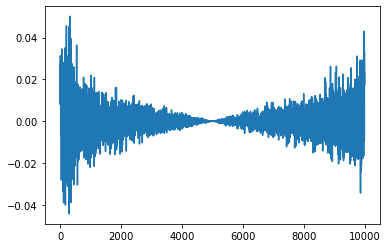

In [4]:

X,y = next(iter(train_dl))
X,y = augment_shift(X,y)
X,y = augment_amp(X,y)
X = torch.tensor(X)
X = torch.complex(X[:,0],X[:,1])

i = 0
c = X[i,:,0]*torch.conj(X[i,:,1])

cc = torch.concatenate([c, torch.zeros(10000 - 2*c.shape[0]),torch.conj(c.flip(dims=(0,)))])
cc = cc /( cc.abs() + 1e-8)

f = torch.fft.ifft(cc)
f = torch.real(f)


plt.plot(f)
w = f.argmax()

if w > 1000:
    w = w - len(f)
print(w)
y[i]

# Histogram over dataset

In [5]:
# res = []
# for X,y in train_dl:
#     X = torch.tensor(X)
#     X = torch.complex(X[:,0],X[:,1])

#     for i in range(X.shape[0]):
#         c = X[i,:,0]*torch.conj(X[i,:,1])

#         cc = torch.concatenate([c, torch.zeros(10000 - 2*c.shape[0]),torch.conj(c.flip(dims=(0,)))])
#         cc = cc /( cc.abs() + 1e-8)

#         f = torch.fft.ifft(cc)
#         f = torch.real(f)
#         w = f.argmax()

#         if w > 1000:
#             w = w - len(f)
#         res.append((y[i] - w).item())
# res = torch.tensor(res)        
# plt.hist(res, bins=50, range=(-50, 50));

# print(f'{(sum(res.abs() < 5)/res.shape[0]).item():.2f} inliers')

In [542]:
def format_simulated_data(X,y):
        """
        transform a tensor of impulse responses in different rooms into pairwise TimeEstimation-problems. Note (X and y should be on GPU)

        """
        #pull a random sound
        sound_paths = glob("../datasets/reference_sounds/*.wav")
        sound_path = sound_paths[np.random.randint(len(sound_paths))]
        fs,signal = wavfile.read(sound_path)
        start = np.random.randint(0,len(signal) - config["sample_length"] - config["rir_len"]-1, X.shape[0])
        # simulate longer sound and then cut to the relevant piece
        signals = np.zeros((X.shape[0], config["sample_length"] + config["rir_len"]-1))
        for i in range(X.shape[0]):
            signals[i,:] = signal[start[i]:start[i]  + config["sample_length"] + config["rir_len"]-1]
        signals = torch.tensor(signals).to(torch.float32).to(device).unsqueeze(1)

        q = torch.fft.irfft(torch.fft.rfft(signals)*torch.fft.rfft(X,signals.shape[2]))[:,:,:config["sample_length"]] # compute the heard sound, and cut it to the right length
        q = torch.fft.rfft(q)[:,:,:config["max_freq"]] # cut frequencies which are too high
        q = q.unsqueeze(2)
        q = torch.concatenate([torch.concatenate([q,q.roll(i+1, 1)], dim=2) for i in range(config["mics_per_batch"] // 2)],dim=1) # organize sounds pairwise
        q = q.view(X.shape[0]*(config["mics_per_batch"]*(config["mics_per_batch"] - 1 ))//2, 2,-1) # reshape so that each example is a row
        X = torch.concatenate([q.real,q.imag],dim=1)
        y = torch.concatenate([y - y.roll(i+1,1) for i in range(config["mics_per_batch"]//2)],dim=1).view(-1)*fs/343 # compute gt for all pairs
        #y = y_to_class_gt(y, config["guess_grid_size"], config["max_shift"]).to(torch.long)
        
        return X,y

def y_to_class_gt(y, guess_grid_size, max_shift) :
        y[y.abs() > max_shift] = max_shift*y[y.abs() > max_shift].sign()

        bin_width = max_shift*2/guess_grid_size
        y = (y/bin_width).round() + guess_grid_size // 2 
        y[y == guess_grid_size] = guess_grid_size - 1
        return y.long()

config = {
    "dropout" : 0.1,
    "batch_size" : 50, 
    "max_shift" : 500, # ~10 meters
    "guess_grid_size" : 100,
    "dataset" : "new_type_dataset_easy.hdf5",
    "cnn_output_size_at_factor_1" : 576,
    "factor" : 10,
    "loss_fn" : "cross_entropy",
    "epochs" : 200,
    "sample_length" : 10000,
    "max_shift" : 100,
    "lr" : 3e-5,
    "n_batch_before_print" : 10,
    "max_freq" : 2500,
    "rir_len" : 1600,
    "rooms_per_batch" : 50,
    "mics_per_batch" : 11,
    "warmup_steps_per_epoch" : 5,
    "warmup_epochs" : 2,
}

f = h5py.File(data_folder + config["dataset"],"r")

X = f['input']
y = f['gt']

class custom_dataset(Dataset):

        def __init__(self, X, y, idx_min=0,dataset_len=len(X)):
                self.X = X
                self.y = y
                self.dataset_len = dataset_len
                self.idx_min = idx_min

        def __getitem__(self, idx):
                return self.X[idx + self.idx_min,:config["mics_per_batch"]],self.y[idx + self.idx_min,:config["mics_per_batch"]]

        def __len__(self):
                return self.dataset_len

# package datasets
split_i = int(X.shape[0]*0.9)
dataset = custom_dataset(X,y, 0, split_i)
dataset_test = custom_dataset(X,y, split_i, X.shape[0] - split_i)
train_dl = DataLoader(dataset, batch_size=config["batch_size"], shuffle=True)
test_dl = DataLoader(dataset_test, batch_size=config["batch_size"], shuffle=False)



GCC-PHAT prediction: 73
Ground truth: 73.1


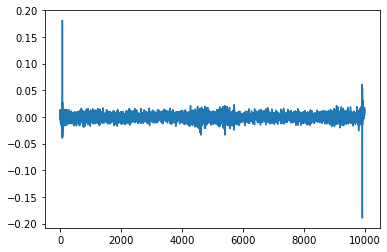

In [543]:
X,y = next(iter(train_dl))
X = X.to(device)
y = y.to(device)
X,y = format_simulated_data(X,y)
X = X.cpu()
X = torch.complex(X[0,0::2,:],X[0,1::2])
c = X[0]*X[1].conj()
pred = torch.fft.irfft(torch.concatenate([c/(c.abs() + 1e-10), torch.zeros(config["sample_length"]//2 - X.shape[1])]))

a = pred.argmax()
if a > pred.shape[0]//2:
    a -= pred.shape[0]

plt.plot(pred)
print(f'GCC-PHAT prediction: {a}')
print(f'Ground truth: {y[0]:.1f}')




In [491]:
X,y = next(iter(train_dl))

imp = X[0,0]

X = X.to(device)
y = y.to(device)
X,y = format_simulated_data(X,y)
X = X.cpu()

X = torch.complex(X[:,0::2],X[:,1::2])
y


tensor([ 12.2087, -43.1393,   5.5792,  ..., 229.9144, 343.6151,   3.3972],
       device='cuda:0')

tensor(12)


tensor(12.2087, device='cuda:0')

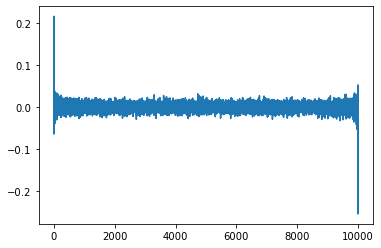

In [492]:

Xt = torch.concatenate([X[0],torch.zeros(2,1 + config["sample_length"]//2 - X.shape[2])], dim=1)

Xt = torch.fft.irfft(Xt)
#Xt = X[0][0:2]
#plt.plot(Xt.T)

c = torch.fft.fft(Xt)

cc = c[0]*c[1].conj()
cc = cc/(cc.abs() + 1e-10)

#plt.plot(cc.T.abs())

f = torch.fft.ifft(cc).real
plt.plot(f)

w = f.argmax()
print(w)
if w > config["sample_length"]//2:
    w = w - len(f)


y[0]




In [472]:

Xt = torch.concatenate([X[0,0],torch.zeros(config["sample_length"]//2 - X.shape[2])])
#plt.plot(torch.fft.irfft(Xt))
#IPython.display.Audio(torch.fft.irfft(Xt), rate=fs)
# #plt.plot(X[0,0].cpu().detach())
# i = 0



#plt.plot(X[i,0,:].real)
cc = torch.concatenate([c, torch.zeros(config["sample_length"]//2 - c.shape[0])])
cc = cc /( cc.abs() + 1e-8)


f = torch.fft.irfft(cc)
f = torch.real(f)


plt.plot(f)

# w = f.argmax()

# if w > config["sample_length"]//2:
#     w = w - len(f)
# print(w)
# y[i]


RuntimeError: Tensors must have same number of dimensions: got 2 and 1

In [453]:
X,y = next(iter(train_dl))
X = X.to(device)
sound_paths = glob("../datasets/reference_sounds/*.wav")
sound_path = sound_paths[np.random.randint(len(sound_paths))]


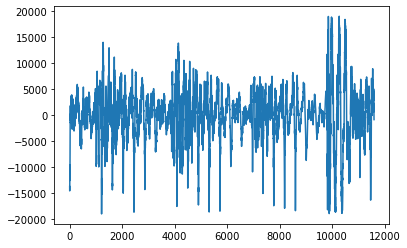

In [454]:
import IPython
fs,signal = wavfile.read(sound_path)
start = np.random.randint(0,len(signal) - config["sample_length"] - config["rir_len"]-1, X.shape[0])
# simulate longer sound and then cut to the relevant piece
signals = np.zeros((X.shape[0], config["sample_length"] + config["rir_len"]-1))
for i in range(X.shape[0]):
    signals[i,:] = signal[start[i]:start[i]  + config["sample_length"] + config["rir_len"]-1]
signals = torch.tensor(signals).to(torch.float32).to(device).unsqueeze(1)
#signals.shape
plt.plot(signals[0,0].cpu())
IPython.display.Audio(signals[0,0].cpu(), rate=fs)

In [458]:
X,y = next(iter(train_dl))
X = X.to(device)
q = torch.fft.irfft(torch.fft.rfft(signals)*torch.fft.rfft(X,signals.shape[2]))[:,:,:config["sample_length"]] # compute the heard sound, and cut it to the right length
q = torch.fft.rfft(q)[:,:,:config["max_freq"]] # cut frequencies which are too high
q = q.unsqueeze(2)
q = torch.concatenate([torch.concatenate([q,q.roll(i+1, 1)], dim=2) for i in range(config["mics_per_batch"] // 2)],dim=1) # organize sounds pairwise
q = q.view(X.shape[0]*(config["mics_per_batch"]*(config["mics_per_batch"] - 1 ))//2, 2,-1) # reshape so that each example is a row


#X = torch.concatenate([q.real,q.imag],dim=1)
#q = q[54,1,:]

q = q.cpu()

#plt.plot(q[0,0,:] - q[0,0,:])

# q = torch.concatenate([q, torch.zeros(config["sample_length"]//2 -  config["max_freq"])])
# plt.plot(torch.fft.irfft(q).cpu())
# IPython.display.Audio(torch.fft.irfft(q).cpu(), rate=fs)

#config["sample_length"]//2 -  config["max_freq"]

# y = torch.concatenate([y - y.roll(i+1,1) for i in range(config["mics_per_batch"]//2)],dim=1).view(-1)*fs/343 # compute gt for all pairs
# y = y_to_class_gt(y, config["guess_grid_size"], config["max_shift"]).to(torch.long)

11599

In [331]:
q

tensor([-52.4801+0.0000j, -54.2907+5.4106j, -48.1522+5.0049j,  ...,
          0.0000+0.0000j,   0.0000+0.0000j,   0.0000+0.0000j])

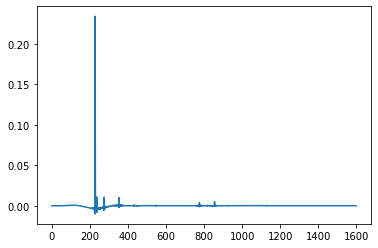

In [141]:
X,y = next(iter(train_dl))
plt.plot(X[0,0,:])